## Derive an RE24 matrix and LWTS from PBP data

Following the methodology described here: https://library.fangraphs.com/the-beginners-guide-to-deriving-woba/

Basic steps:

1. Compute an RE24 table by grouping all events based on starting base-out state and looking at runs scored from those situations.
2. For each PA, add the starting RE, ending RE, and the change in RE.
3. Group all of that by event type to get an average run value for each event type.
4. Store off a PA data table, which includes RE and run value fields, to use in further analysis.

Now that we have this PA table, there are all sorts of things we could do next:
* Compute wOBA weights
* Aggregate run value or RE along various dimensions (e.g., on batter or pitcher)
* Create a model to predict run value of a particular PA (e.g., based on batter and pitcher stats)

In [1]:
import pandas as pd
import numpy as np
import boxball_loader as bbl

In [2]:
YEARS = bbl.Seasons(2000, 2019)
cols = ['game_id', 'fate_runs_ct', 'event_runs_ct', 'outs_ct', 'event_outs_ct', 'start_bases_cd', 
        'inn_ct', 'bat_home_id', 'end_bases_cd', 'game_pa_ct', 'game_end_fl', 'pit_id', 'bat_id', 
        'bat_hand_cd', 'event_cd', 'resp_pit_hand_cd', 'resp_bat_hand_cd'
]


In [3]:
ev = bbl.load_event_data(seasons=YEARS, requested_columns=cols, pa_only=False)


In [4]:
ev.columns

Index(['game_id', 'date', 'game_type', 'resp_pit_hand_cd', 'event_cd',
       'bat_id', 'event_outs_ct', 'ab_fl', 'game_pa_ct', 'end_bases_cd',
       'bat_hand_cd', 'tb_ct', 'bat_home_id', 'outs_ct', 'start_bases_cd',
       'fate_runs_ct', 'resp_bat_hand_cd', 'game_end_fl', 'inn_ct',
       'bat_event_fl', 'event_runs_ct', 'pit_id', 'h_fl', 'ob_fl', 'yr'],
      dtype='object')

In [5]:
# Add a couple columns for computing RE24
ev['runs_finish_ct']=ev.fate_runs_ct+ev.event_runs_ct #total runs in remainder of inning
ev['end_outs_ct']=ev.outs_ct+ev.event_outs_ct # outs at end of event

In [7]:
# Choose which games we want
gms = bbl.load_gamelogs(game_types=bbl.GameType.RS, seasons=YEARS)

evs = ev[ev.game_id.isin(gms.game_id)]
evs.shape

(3846594, 27)

In [8]:
# Generate a basic RE24 table
re24 = evs.groupby(['start_bases_cd', 'outs_ct'])['runs_finish_ct'].mean().unstack()
re24[3] = re24[2]*0
re24 = re24.unstack()
re24

outs_ct  start_bases_cd
0        0                 0.511845
         1                 0.895798
         2                 1.142028
         3                 1.490203
         4                 1.416561
         5                 1.802290
         6                 2.007698
         7                 2.304029
1        0                 0.273873
         1                 0.535192
         2                 0.694084
         3                 0.926731
         4                 0.968167
         5                 1.184296
         6                 1.409886
         7                 1.573842
2        0                 0.105753
         1                 0.232675
         2                 0.330364
         3                 0.446338
         4                 0.369960
         5                 0.504265
         6                 0.586408
         7                 0.776616
3        0                 0.000000
         1                 0.000000
         2                 0.000000
    

In [9]:
def get_printable_re24table(re24):
    df = re24.reset_index()
    start_bases_txt = df['start_bases_cd'].apply(lambda x: ['___', '1__', '_2_', '12_', '__3', '1_3', '_23', '123'][int(x)])
    df['bases'] = start_bases_txt
    printable = df.rename(columns={0: 'run_exp', 'outs_ct': 'outs'}) \
        .set_index(['outs', 'bases']) \
        .unstack(level=0) \
        .sort_values(by=('start_bases_cd', 0))['run_exp']

    return printable.to_markdown()

print(get_printable_re24table(re24))

| bases   |        0 |        1 |        2 |   3 |
|:--------|---------:|---------:|---------:|----:|
| ___     | 0.511845 | 0.273873 | 0.105753 |   0 |
| 1__     | 0.895798 | 0.535192 | 0.232675 |   0 |
| _2_     | 1.14203  | 0.694084 | 0.330364 |   0 |
| 12_     | 1.4902   | 0.926731 | 0.446338 |   0 |
| __3     | 1.41656  | 0.968167 | 0.36996  |   0 |
| 1_3     | 1.80229  | 1.1843   | 0.504265 |   0 |
| _23     | 2.0077   | 1.40989  | 0.586408 |   0 |
| 123     | 2.30403  | 1.57384  | 0.776616 |   0 |


In [10]:
evs['score_left'] = np.where(evs['runs_finish_ct']>0, 1, 0)
evs.groupby(['start_bases_cd', 'outs_ct'])['score_left'].mean().unstack()

outs_ct,0,1,2
start_bases_cd,,,
0,0.280065,0.164609,0.071551
1,0.425276,0.272983,0.130173
2,0.622033,0.406246,0.219737
3,0.623717,0.418673,0.228478
4,0.841254,0.658379,0.260029
5,0.857479,0.641581,0.277002
6,0.855245,0.682529,0.264072
7,0.863084,0.667894,0.325626


In [11]:
gms.shape

(48588, 164)

In [12]:
half_innings = len(evs[['game_id', 'inn_ct', 'bat_home_id']].drop_duplicates())
half_innings

870031

In [13]:
# Now compute RE24 for each event
def add_REs_to_events(evs):
    # Add the re_start and re_end to each event (merge is faster than a lookup)
    e_s = pd.merge(left=evs, right=re24.rename('re_start'), on=['start_bases_cd', 'outs_ct'])
    e_e = pd.merge(left=e_s, right=re24.rename('re_end'), \
               left_on=['end_bases_cd', 'end_outs_ct'], \
               right_on=['start_bases_cd', 'outs_ct'])
    e_e['re_added'] = e_e['re_end'] - e_e['re_start'] + e_e['event_runs_ct']
    return e_e.sort_values(['game_id', 'inn_ct', 'bat_home_id', 'game_pa_ct'])

In [14]:
evs_re = add_REs_to_events(evs)
evs_re.head(20)

,game_id,date,game_type,resp_pit_hand_cd,event_cd,bat_id,event_outs_ct,ab_fl,game_pa_ct,end_bases_cd,...,pit_id,h_fl,ob_fl,yr,runs_finish_ct,end_outs_ct,score_left,re_start,re_end,re_added
34,ANA200004030,2000-04-03,RS,R,20,knobc001,0,True,0,1,...,hillk001,1,1,2000,0,0,0,0.511845,0.895798,0.383953
833867,ANA200004030,2000-04-03,RS,R,6,jeted001,1,False,1,0,...,hillk001,0,0,2000,0,1,0,0.895798,0.273873,-0.621926
1076981,ANA200004030,2000-04-03,RS,R,2,jeted001,1,True,1,0,...,hillk001,0,0,2000,0,2,0,0.273873,0.105753,-0.168120
2425980,ANA200004030,2000-04-03,RS,R,14,oneip001,0,False,2,1,...,hillk001,0,1,2000,0,2,0,0.105753,0.232675,0.126923
3177635,ANA200004030,2000-04-03,RS,R,2,willb002,1,True,3,1,...,hillk001,0,0,2000,0,3,0,0.232675,0.000000,-0.232675
35,ANA200004030,2000-04-03,RS,R,20,erstd001,0,True,0,1,...,herno001,1,1,2000,0,0,0,0.511845,0.895798,0.383953
1049759,ANA200004030,2000-04-03,RS,R,2,kenna001,2,True,1,0,...,herno001,0,0,2000,0,2,0,0.895798,0.105753,-0.790045
2683783,ANA200004030,2000-04-03,RS,R,3,vaugm001,1,True,2,0,...,herno001,0,0,2000,0,3,0,0.105753,0.000000,-0.105753
223904,ANA200004030,2000-04-03,RS,R,2,martt002,1,True,4,0,...,hillk001,0,0,2000,0,1,0,0.511845,0.273873,-0.237973
1076982,ANA200004030,2000-04-03,RS,R,2,leder001,1,True,5,0,...,hillk001,0,0,2000,0,2,0,0.273873,0.105753,-0.168120


In [15]:
# Just to sanity check, let's compute the sum by pitcher
evs_re.groupby('pit_id')['re_added'].sum().sort_values()

pit_id
kersc001   -497.396874
verlj001   -359.383800
greiz001   -318.304294
schem001   -307.146099
hallr001   -282.549878
               ...    
bellr003    116.979340
fossc001    122.495884
jacke001    129.999578
elars001    134.839496
limaj001    160.706304
Name: re_added, Length: 3308, dtype: float64

In [16]:
# What does total re_added sum to?
evs_re.re_added.sum()

1981.0899084354028

We might've expected the sum to come out to zero.  But it doesn't exactly, because RE24[0][0] isn't exactly equal to the the number of runs per inning.  This is because there are other [0][0] occurrences (e.g., after a leadoff HR) that are included in the re24[0][0] calculation.

In [17]:
evs_re[evs_re.game_end_fl].re_end.sum()

2901.3359178147193

In [18]:
# Now look at average RE change by event code
# This is the context-neutral run value of each event type
event_res = evs_re.groupby('event_cd').agg({'re_added': np.mean})['re_added'].rename('event_re')
event_res

event_cd
2    -0.275642
3    -0.277176
4     0.179787
5     0.112314
6    -0.439912
8    -0.241721
9     0.261552
10    0.271778
11    0.265234
12   -0.424492
13    0.000000
14    0.311160
15    0.172916
16    0.333190
17    0.363501
18    0.499623
19   -0.203316
20    0.456638
21    0.762297
22    1.053653
23    1.391234
Name: event_re, dtype: float64

In [19]:
event_res.to_csv('~/temp/event_res.csv')

In [20]:
# Annotate each event with the context-neutral run value of the event type
evs_re = pd.merge(left=evs_re, right=event_res, on='event_cd') \
    .sort_values(['game_id', 'inn_ct', 'bat_home_id', 'game_pa_ct'])

evs_re.head(20)

,game_id,date,game_type,resp_pit_hand_cd,event_cd,bat_id,event_outs_ct,ab_fl,game_pa_ct,end_bases_cd,...,h_fl,ob_fl,yr,runs_finish_ct,end_outs_ct,score_left,re_start,re_end,re_added,event_re
0,ANA200004030,2000-04-03,RS,R,20,knobc001,0,True,0,1,...,1,1,2000,0,0,0,0.511845,0.895798,0.383953,0.456638
568564,ANA200004030,2000-04-03,RS,R,6,jeted001,1,False,1,0,...,0,0,2000,0,1,0,0.895798,0.273873,-0.621926,-0.439912
583539,ANA200004030,2000-04-03,RS,R,2,jeted001,1,True,1,0,...,0,0,2000,0,2,0,0.273873,0.105753,-0.168120,-0.275642
2357272,ANA200004030,2000-04-03,RS,R,14,oneip001,0,False,2,1,...,0,1,2000,0,2,0,0.105753,0.232675,0.126923,0.311160
583540,ANA200004030,2000-04-03,RS,R,2,willb002,1,True,3,1,...,0,0,2000,0,3,0,0.232675,0.000000,-0.232675,-0.275642
1,ANA200004030,2000-04-03,RS,R,20,erstd001,0,True,0,1,...,1,1,2000,0,0,0,0.511845,0.895798,0.383953,0.456638
583541,ANA200004030,2000-04-03,RS,R,2,kenna001,2,True,1,0,...,0,0,2000,0,2,0,0.895798,0.105753,-0.790045,-0.275642
2647277,ANA200004030,2000-04-03,RS,R,3,vaugm001,1,True,2,0,...,0,0,2000,0,3,0,0.105753,0.000000,-0.105753,-0.277176
583542,ANA200004030,2000-04-03,RS,R,2,martt002,1,True,4,0,...,0,0,2000,0,1,0,0.511845,0.273873,-0.237973,-0.275642
583543,ANA200004030,2000-04-03,RS,R,2,leder001,1,True,5,0,...,0,0,2000,0,2,0,0.273873,0.105753,-0.168120,-0.275642


In [21]:
evs_re.to_parquet('~/temp/evs_re.parquet')

In [22]:
# Let's repeat the sanity check, let's compute the sum by pitcher
# Should see the context-sensitive and context-neutral match up
evs_re.groupby('pit_id')[['re_added', 'event_re']].sum().sort_values(by='re_added')

,re_added,event_re
pit_id,,
kersc001,-497.396874,-502.050440
verlj001,-359.383800,-413.884602
greiz001,-318.304294,-303.257852
schem001,-307.146099,-330.552428
hallr001,-282.549878,-296.074557
...,...,...
bellr003,116.979340,111.854961
fossc001,122.495884,97.499176
jacke001,129.999578,139.950315


In [23]:
# Now repeat for batters
# Should see the context-sensitive and context-neutral match up
evs_re.groupby('bat_id')[['re_added', 'event_re']].sum().sort_values(by='re_added')

,re_added,event_re
bat_id,,
iztuc001,-231.810778,-197.143952
escoa003,-220.947658,-204.347832
mathj001,-182.114878,-202.342228
ausmb001,-179.327986,-127.377301
gonza002,-167.595904,-136.073412
...,...,...
rodra001,619.511385,603.805152
heltt001,620.900437,583.666871
ortid001,643.251091,579.608113


In [24]:
pa = evs_re
pa.groupby('event_cd').agg({'re_added': np.mean})

,re_added
event_cd,
2,-0.275642
3,-0.277176
4,0.179787
5,0.112314
6,-0.439912
8,-0.241721
9,0.261552
10,0.271778
11,0.265234


In [25]:
# We'll start simple: consider only uBB, HBP, 1B, 2B, 3B, HR; ignore IBB and Interference; everything else is an "out"

# First the positives
success_cols = [14, 16, 20, 21, 22, 23]
ignore_cols = [15, 17]
success_weights = pa[pa.event_cd.isin(success_cols)].groupby('event_cd') \
    .agg({'re_added': [len, np.mean]})['re_added'] \
    .rename(columns={'len': 'ct', 'mean': 're_added'})

success_weights

,ct,re_added
event_cd,,
14,290005.0,0.311160
16,34246.0,0.333190
20,568564.0,0.456638
21,172299.0,0.762297
22,17797.0,1.053653
23,104079.0,1.391234


In [26]:
out_weights = pa[~pa.event_cd.isin(success_cols+ignore_cols)] \
    .agg({'re_added': [len, np.mean]}) \
    .rename(columns={'re_added': 'out'}) \
    .T.rename(columns={'len': 'ct', 'mean': 're_added'})
out_weights

,ct,re_added
out,2635865.0,-0.249782


In [27]:
weights = pd.concat([success_weights, out_weights])
weights

,ct,re_added
14,290005.0,0.311160
16,34246.0,0.333190
20,568564.0,0.456638
21,172299.0,0.762297
22,17797.0,1.053653
23,104079.0,1.391234
out,2635865.0,-0.249782


In [28]:
out_value=out_weights['re_added'][0]
out_value

-0.2497820737949269

In [29]:
weights['re_over_out'] = weights.re_added-out_value
weights

,ct,re_added,re_over_out
14,290005.0,0.311160,0.560942
16,34246.0,0.333190,0.582973
20,568564.0,0.456638,0.706420
21,172299.0,0.762297,1.012079
22,17797.0,1.053653,1.303435
23,104079.0,1.391234,1.641017
out,2635865.0,-0.249782,0.000000


In [30]:
raw_woba = sum(weights['ct']*weights['re_over_out'])/sum(weights['ct'])
raw_woba

0.2492007082120126

In [31]:
sum(weights['ct']*weights['re_over_out'])

952658.1733918334

In [32]:
target_woba = .315
woba_scale = target_woba/raw_woba
weights['woba_wt'] = weights['re_over_out']*woba_scale
weights, woba_scale

(            ct  re_added  re_over_out   woba_wt
 14    290005.0  0.311160     0.560942  0.709054
 16     34246.0  0.333190     0.582973  0.736901
 20    568564.0  0.456638     0.706420  0.892944
 21    172299.0  0.762297     1.012079  1.279310
 22     17797.0  1.053653     1.303435  1.647596
 23    104079.0  1.391234     1.641017  2.074313
 out  2635865.0 -0.249782     0.000000  0.000000,
 1.2640413514876825)

OK, so that gives us wOBA weights!

In [33]:
def summarize_stats(pa, groupby):
    counters_map = {'bat_event_fl': 'pa', 'ob_fl': 'ob', 'ab_fl': 'ab', 'h_fl': 'h', 'tb_ct': 'tb'}
    groups = pa.groupby(groupby)
    stats = groups[list(counters_map.keys())].sum().rename(columns=counters_map)
    stats['ba'] = stats['h']/stats['ab']
    stats['obp'] = stats['ob']/stats['pa']
    stats['slg'] = stats['tb']/stats['ab']
    woba_weights = {'ob': .702, 'tb': .37, 'h': -.21}
    stats['woba'] = sum([stats[stat]*woba_weights[stat] for stat in woba_weights.keys()])/stats['pa']
    return stats

In [34]:
summarize_stats(pa, ['bat_hand_cd'])

,pa,ob,ab,h,tb,ba,obp,slg,woba
bat_hand_cd,,,,,,,,,
?,1,0,1,0,0.0,0.000000,0.000000,0.000000,0.000000
L,1575705,512253,1394744,364410,584593.0,0.261274,0.325094,0.419140,0.316922
R,2150768,674737,1929165,498329,798276.0,0.258313,0.313719,0.413794,0.308903


## Modeling individual PAs

### Measure outcome: run value based on event code
### Batter estimate (wOBA)
### Pitcher estimate (wOBA allowed)
### Regression or other model

In [35]:
batters = pa.groupby('bat_id')['event_re'].mean().rename('bat_re_avg')
batters

bat_id
aardd001   -0.276255
abada001   -0.123478
abadf001   -0.195130
abboj002   -0.003291
abbok002   -0.033651
              ...   
zobrb001    0.015588
zoccp001   -0.135768
zoske001   -0.276025
zulej001    0.006954
zunim001   -0.028183
Name: bat_re_avg, Length: 4597, dtype: float64

In [36]:
pitchers = pa.groupby('pit_id')['event_re'].mean().rename('pit_re_avg')
pitchers

pit_id
aardd001   -0.002589
abadf001   -0.010613
abbop001    0.013814
abreb002   -0.111076
abrej002    0.041484
              ...   
zinkc001    0.124365
zitob001   -0.009095
zobrb001   -0.041228
zumaj001   -0.021079
zycht001   -0.036135
Name: pit_re_avg, Length: 3308, dtype: float64

In [37]:
pa = pd.merge(left=pa, right=batters, on='bat_id')
pa = pd.merge(left=pa, right=pitchers, on='pit_id')

In [38]:
pa = pa.sort_values(['game_id', 'inn_ct', 'bat_home_id', 'game_pa_ct'])
pa

,game_id,date,game_type,resp_pit_hand_cd,event_cd,bat_id,event_outs_ct,ab_fl,game_pa_ct,end_bases_cd,...,yr,runs_finish_ct,end_outs_ct,score_left,re_start,re_end,re_added,event_re,bat_re_avg,pit_re_avg
0,ANA200004030,2000-04-03,RS,R,20,knobc001,0,True,0,1,...,2000,0,0,0,0.511845,0.895798,0.383953,0.456638,-0.012795,0.075442
3,ANA200004030,2000-04-03,RS,R,6,jeted001,1,False,1,0,...,2000,0,1,0,0.895798,0.273873,-0.621926,-0.439912,0.028679,0.075442
4,ANA200004030,2000-04-03,RS,R,2,jeted001,1,True,1,0,...,2000,0,2,0,0.273873,0.105753,-0.168120,-0.275642,0.028679,0.075442
7,ANA200004030,2000-04-03,RS,R,14,oneip001,0,False,2,1,...,2000,0,2,0,0.105753,0.232675,0.126923,0.311160,0.008335,0.075442
10,ANA200004030,2000-04-03,RS,R,2,willb002,1,True,3,1,...,2000,0,3,0,0.232675,0.000000,-0.232675,-0.275642,0.034834,0.075442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1467638,WAS201909290,2019-09-29,RS,R,3,steva001,1,True,37,5,...,2019,0,2,0,1.184296,0.504265,-0.680031,-0.277176,-0.034725,-0.016142
1467772,WAS201909290,2019-09-29,RS,R,2,barrt004,1,True,38,5,...,2019,0,3,0,0.504265,0.000000,-0.504265,-0.275642,-0.275642,-0.016142
3780153,WAS201909290,2019-09-29,RS,R,14,bauej001,0,False,33,1,...,2019,0,0,0,0.511845,0.895798,0.383953,0.311160,-0.019489,0.026599
3780149,WAS201909290,2019-09-29,RS,R,2,merco003,2,True,34,0,...,2019,0,2,0,0.895798,0.105753,-0.790045,-0.275642,0.002606,0.026599


In [39]:
pa['handedness'] = pa['resp_pit_hand_cd']+pa['resp_bat_hand_cd']
pa['handedness'].sample(10)

2868808    RR
1664859    RR
1331444    RL
3454074    RR
3093290    LR
1577968    LR
2450729    RL
3348567    RR
2124508    RR
3034368    RL
Name: handedness, dtype: object

In [40]:
import statsmodels.api as sm

In [41]:
X = pd.concat([pa[['bat_re_avg', 'pit_re_avg']], pd.get_dummies(pa['handedness'])], axis=1)
y = pa['event_re']
#X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               event_re   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     7493.
Date:                Wed, 25 May 2022   Prob (F-statistic):               0.00
Time:                        20:16:23   Log-Likelihood:            -2.0967e+06
No. Observations:             3846594   AIC:                         4.193e+06
Df Residuals:                 3846587   BIC:                         4.193e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
bat_re_avg     1.0057      0.006    181.584      0.000       0.995       1.017
pit_re_avg     0.9938      0.010    101.201      0.000       0.975       1.013
B?            -0.2637      0.417     -0.632      0.527      -1.082       0.554
LL            -0.0251      0.001    -32.591      0.000      -0.027      -0.024
LR             0.0095      0.000     19.579      0.000       0.009       0.010
RL             0.0052      0.000     14.478      0.000       0.005       0.006
RR            -0.0058      0.000    -16.963      0.000      -0.006      -0.005
==============================================================================
Omnibus:                   801917.979   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1432908.994
Skew:                           1.354   Prob(JB):                         0.00
Kurtosis:                       4.268   Cond. No.                     1.22e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.22e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
predictions

0          0.056282
3          0.097992
4          0.097992
7          0.088595
10         0.115244
             ...   
1467638   -0.045723
1467772   -0.299068
3780153    0.012074
3780149    0.023232
3780154   -0.117444
Length: 3846594, dtype: float64

In [43]:
pa['re_predicted']=predictions

In [44]:
pa.groupby('bat_id')['re_predicted'].sum().sort_values()

bat_id
escoa003   -240.655345
mathj001   -215.713350
iztuc001   -149.821704
haraa001   -144.716383
hecha001   -140.951511
               ...    
bondb001    596.960494
berkl001    607.107430
cabrm001    610.318711
rodra001    611.303270
pujoa001    718.824704
Name: re_predicted, Length: 4597, dtype: float64

In [45]:
pd.get_dummies(pa['handedness'])

,B?,LL,LR,RL,RR
0,0,0,0,0,1
3,0,0,0,0,1
4,0,0,0,0,1
7,0,0,0,1,0
10,0,0,0,1,0
...,...,...,...,...,...
1467638,0,0,0,1,0
1467772,0,0,0,0,1
3780153,0,0,0,1,0
3780149,0,0,0,0,1


In [46]:
pa.to_parquet('../data/mine/pa2015-2020.parquet')

OK, so now we can predict individual PAs.  The r^2 is very low (.013) because of the variability of PAs.  How about if we look at cohorts?

In [47]:
# make 20 buckets, bucketing *the PA*.  So each bucket will have the same number of PA, not batters
bat_buckets = pd.qcut(pa.bat_re_avg, q=20).rename('bat_bucket')
bat_buckets

0          (-0.0128, -0.00938]
3             (0.0262, 0.0312]
4             (0.0262, 0.0312]
7            (0.00675, 0.0096]
10            (0.0312, 0.0377]
                  ...         
1467638      (-0.0512, -0.033]
1467772       (-0.36, -0.0512]
3780153     (-0.0247, -0.0185]
3780149     (0.00144, 0.00446]
3780154       (-0.36, -0.0512]
Name: bat_bucket, Length: 3846594, dtype: category
Categories (20, interval[float64]): [(-0.36, -0.0512] < (-0.0512, -0.033] < (-0.033, -0.0247] < (-0.0247, -0.0185] ... (0.0262, 0.0312] < (0.0312, 0.0377] < (0.0377, 0.0489] < (0.0489, 1.054]]

In [48]:
# make 20 buckets, bucketing *the PA*.  So each bucket will have the same number of PA, not pitchers
pit_buckets = pd.qcut(pa.pit_re_avg, q=20).rename('pit_bucket')
pit_buckets

0             (0.0344, 0.851]
3             (0.0344, 0.851]
4             (0.0344, 0.851]
7             (0.0344, 0.851]
10            (0.0344, 0.851]
                  ...        
1467638    (-0.0194, -0.0158]
1467772    (-0.0194, -0.0158]
3780153      (0.0242, 0.0344]
3780149      (0.0242, 0.0344]
3780154      (0.0242, 0.0344]
Name: pit_bucket, Length: 3846594, dtype: category
Categories (20, interval[float64]): [(-0.278, -0.0321] < (-0.0321, -0.0244] < (-0.0244, -0.0194] < (-0.0194, -0.0158] ... (0.0152, 0.0184] < (0.0184, 0.0242] < (0.0242, 0.0344] < (0.0344, 0.851]]

In [49]:
pa.groupby(bat_buckets)['bat_re_avg'].mean()

bat_bucket
(-0.36, -0.0512]       -0.118557
(-0.0512, -0.033]      -0.039633
(-0.033, -0.0247]      -0.028240
(-0.0247, -0.0185]     -0.021383
(-0.0185, -0.0128]     -0.015273
(-0.0128, -0.00938]    -0.010844
(-0.00938, -0.00505]   -0.007214
(-0.00505, -0.00128]   -0.003178
(-0.00128, 0.00144]    -0.000114
(0.00144, 0.00446]      0.003038
(0.00446, 0.00675]      0.005593
(0.00675, 0.0096]       0.008288
(0.0096, 0.013]         0.011307
(0.013, 0.016]          0.014718
(0.016, 0.0212]         0.018889
(0.0212, 0.0262]        0.023544
(0.0262, 0.0312]        0.028532
(0.0312, 0.0377]        0.034165
(0.0377, 0.0489]        0.043697
(0.0489, 1.054]         0.063822
Name: bat_re_avg, dtype: float64

In [50]:
summarize_stats(pa, bat_buckets)

,pa,ob,ab,h,tb,ba,obp,slg,woba
bat_bucket,,,,,,,,,
"(-0.36, -0.0512]",188027,35262,166218,26691,35832.0,0.160578,0.187537,0.215572,0.172351
"(-0.0512, -0.033]",186711,52296,169441,39265,56554.0,0.231733,0.280091,0.333768,0.264532
"(-0.033, -0.0247]",186607,54668,169376,41474,60088.0,0.244863,0.292958,0.354761,0.278124
"(-0.0247, -0.0185]",188247,56030,170843,42539,63315.0,0.248995,0.297641,0.370603,0.285935
"(-0.0185, -0.0128]",185699,56745,168300,42978,63941.0,0.255365,0.305575,0.379923,0.293312
"(-0.0128, -0.00938]",186391,58177,167932,43204,65121.0,0.257271,0.312123,0.387782,0.299704
"(-0.00938, -0.00505]",186772,58417,168279,43195,67103.0,0.256687,0.312772,0.398760,0.303931
"(-0.00505, -0.00128]",185862,58654,167504,43393,68576.0,0.259057,0.315578,0.409399,0.309023
"(-0.00128, 0.00144]",186764,60030,168291,44387,69058.0,0.263751,0.321422,0.410349,0.312540


In [51]:
summarize_stats(pa, pit_buckets)

,pa,ob,ab,h,tb,ba,obp,slg,woba
pit_bucket,,,,,,,,,
"(-0.278, -0.0321]",193834,52255,175348,37185,59030.0,0.212064,0.269586,0.336645,0.261643
"(-0.0321, -0.0244]",179385,51693,161912,37623,58627.0,0.232367,0.288168,0.362092,0.279174
"(-0.0244, -0.0194]",191436,56556,172739,41621,64651.0,0.240947,0.295430,0.374270,0.286690
"(-0.0194, -0.0158]",182206,54277,163276,39196,62293.0,0.240060,0.297888,0.381520,0.290439
"(-0.0158, -0.0127]",184954,56013,165777,40274,64100.0,0.242941,0.302848,0.386664,0.295104
"(-0.0127, -0.00911]",185439,56678,166197,41374,65317.0,0.248946,0.305642,0.393010,0.298032
"(-0.00911, -0.0061]",185815,57975,165532,41547,65620.0,0.250991,0.312004,0.396419,0.302736
"(-0.0061, -0.0041]",187670,58569,168184,42759,68004.0,0.254239,0.312085,0.404343,0.305310
"(-0.0041, -0.0022]",189654,59450,170392,43872,70532.0,0.257477,0.313466,0.413940,0.309077


In [52]:
bucketed = pa.groupby([bat_buckets, pit_buckets])[['bat_re_avg', 'pit_re_avg', 'event_re']].mean()
bucketed

bat_re_avg  pit_re_avg  event_re
bat_bucket       pit_bucket                                          
(-0.36, -0.0512] (-0.278, -0.0321]    -0.105207   -0.042749 -0.134285
                 (-0.0321, -0.0244]   -0.115340   -0.027478 -0.135527
                 (-0.0244, -0.0194]   -0.118691   -0.021534 -0.134187
                 (-0.0194, -0.0158]   -0.119748   -0.017660 -0.134749
                 (-0.0158, -0.0127]   -0.111426   -0.014422 -0.121562
...                                         ...         ...       ...
(0.0489, 1.054]  (0.012, 0.0152]       0.064190    0.013509  0.082268
                 (0.0152, 0.0184]      0.064017    0.016916  0.082957
                 (0.0184, 0.0242]      0.064584    0.020805  0.095871
                 (0.0242, 0.0344]      0.064113    0.028520  0.096495
                 (0.0344, 0.851]       0.064647    0.052627  0.115915

[400 rows x 3 columns]

In [53]:
X = bucketed[['bat_re_avg', 'pit_re_avg']]
y = bucketed['event_re']
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               event_re   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                 1.234e+04
Date:                Wed, 25 May 2022   Prob (F-statistic):               0.00
Time:                        20:16:30   Log-Likelihood:                 1531.4
No. Observations:                 400   AIC:                            -3057.
Df Residuals:                     397   BIC:                            -3045.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0005      0.000     -1.995      0.047      -0.001    -7.8e-06
bat_re_avg     0.9937      0.007    137.117      0.000       0.979       1.008
pit_re_avg     0.9908      0.013     77.122      0.000       0.966       1.016
==============================================================================
Omnibus:                       14.287   Durbin-Watson:                   1.693
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               26.289
Skew:                          -0.184   Prob(JB):                     1.96e-06
Kurtosis:                       4.201   Cond. No.                         48.7
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This is great!  This gives basically the same prediction model as when we went PA-by-PA (very similar coefficients), but now with an r^2 of .96.  I think this shows that the model is good, but the PA-by-PA evaluation is necessarily going to show low r^2 due to variation.

In [54]:
model

### Umpires

In [55]:
gms.columns.values

array(['date', 'double_header', 'day_of_week', 'visiting_team',
       'visiting_team_league', 'visiting_team_game_number', 'home_team',
       'home_team_league', 'home_team_game_number', 'visitor_runs_scored',
       'home_runs_scored', 'length_in_outs', 'day_night',
       'completion_info', 'forfeit_info', 'protest_info', 'park_id',
       'attendance', 'duration', 'visitor_line_score', 'home_line_score',
       'visitor_ab', 'visitor_h', 'visitor_d', 'visitor_t', 'visitor_hr',
       'visitor_rbi', 'visitor_sh', 'visitor_sf', 'visitor_hbp',
       'visitor_bb', 'visitor_ibb', 'visitor_k', 'visitor_sb',
       'visitor_cs', 'visitor_gdp', 'visitor_ci', 'visitor_lob',
       'visitor_pitchers', 'visitor_er', 'visitor_ter', 'visitor_wp',
       'visitor_balks', 'visitor_po', 'visitor_a', 'visitor_e',
       'visitor_passed', 'visitor_db', 'visitor_tp', 'home_ab', 'home_h',
       'home_d', 'home_t', 'home_hr', 'home_rbi', 'home_sh', 'home_sf',
       'home_hbp', 'home_bb', 'home_ibb'

In [56]:
gms[['game_id', 'umpire_h_id']]

,game_id,umpire_h_id
9728,NYN200003290,marsr901
9729,CHN200003300,herna901
9732,FLO200004030,demud901
9739,OAK200004030,monte901
9738,MIN200004030,reedr901
...,...,...
8931,PHI201909290,millb901
8930,NYN201909290,porta901
8929,COL201909290,gibsh902
8928,ARI201909290,muchm901


In [57]:
pa_w_ump = pd.merge(left=pa, right=gms[['game_id', 'umpire_h_id']], on='game_id')
pa_w_ump

,game_id,date,game_type,resp_pit_hand_cd,event_cd,bat_id,event_outs_ct,ab_fl,game_pa_ct,end_bases_cd,...,score_left,re_start,re_end,re_added,event_re,bat_re_avg,pit_re_avg,handedness,re_predicted,umpire_h_id
0,ANA200004030,2000-04-03,RS,R,20,knobc001,0,True,0,1,...,0,0.511845,0.895798,0.383953,0.456638,-0.012795,0.075442,RR,0.056282,mcclt901
1,ANA200004030,2000-04-03,RS,R,6,jeted001,1,False,1,0,...,0,0.895798,0.273873,-0.621926,-0.439912,0.028679,0.075442,RR,0.097992,mcclt901
2,ANA200004030,2000-04-03,RS,R,2,jeted001,1,True,1,0,...,0,0.273873,0.105753,-0.168120,-0.275642,0.028679,0.075442,RR,0.097992,mcclt901
3,ANA200004030,2000-04-03,RS,R,14,oneip001,0,False,2,1,...,0,0.105753,0.232675,0.126923,0.311160,0.008335,0.075442,RL,0.088595,mcclt901
4,ANA200004030,2000-04-03,RS,R,2,willb002,1,True,3,1,...,0,0.232675,0.000000,-0.232675,-0.275642,0.034834,0.075442,RL,0.115244,mcclt901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3846589,WAS201909290,2019-09-29,RS,R,3,steva001,1,True,37,5,...,0,1.184296,0.504265,-0.680031,-0.277176,-0.034725,-0.016142,RL,-0.045723,blasc901
3846590,WAS201909290,2019-09-29,RS,R,2,barrt004,1,True,38,5,...,0,0.504265,0.000000,-0.504265,-0.275642,-0.275642,-0.016142,RR,-0.299068,blasc901
3846591,WAS201909290,2019-09-29,RS,R,14,bauej001,0,False,33,1,...,0,0.511845,0.895798,0.383953,0.311160,-0.019489,0.026599,RL,0.012074,blasc901
3846592,WAS201909290,2019-09-29,RS,R,2,merco003,2,True,34,0,...,0,0.895798,0.105753,-0.790045,-0.275642,0.002606,0.026599,RR,0.023232,blasc901


In [58]:
summarize_stats(pa_w_ump, 'umpire_h_id')

,pa,ob,ab,h,tb,ba,obp,slg,woba
umpire_h_id,,,,,,,,,
addir901,3336,1026,2968,722,1217,0.243261,0.307554,0.410040,0.305432
armer901,910,282,817,208,323,0.254590,0.309890,0.395349,0.300873
aschd901,615,202,547,150,242,0.274223,0.328455,0.442413,0.324950
bacoj901,467,150,426,115,203,0.269953,0.321199,0.476526,0.334604
bakej902,17315,5456,15449,3905,6363,0.252767,0.315103,0.411871,0.309811
...,...,...,...,...,...,...,...,...,...
wintm901,47622,15251,42486,11096,17627,0.261168,0.320251,0.414890,0.312839
wolcq901,14267,4559,12789,3329,5352,0.260302,0.319549,0.418485,0.314121
wolfj901,46327,14795,41459,10903,17428,0.262983,0.319360,0.420367,0.313960


In [59]:
ump_stats = pa_w_ump.groupby('umpire_h_id').agg({'bat_event_fl': len, 're_predicted': np.mean , 'event_re': np.mean}).rename(columns={'bat_event_fl': 'pa'})
ump_stats

,pa,re_predicted,event_re
umpire_h_id,,,
addir901,3442,-0.003735,-0.005047
armer901,943,0.002429,-0.007897
aschd901,641,0.004694,0.010541
bacoj901,478,-0.001500,0.014321
bakej902,17845,-0.006979,-0.002927
...,...,...,...
wintm901,49182,0.001489,0.001300
wolcq901,14725,-0.006359,0.001595
wolfj901,47786,0.000842,0.001931


<AxesSubplot:xlabel='re_predicted', ylabel='event_re'>

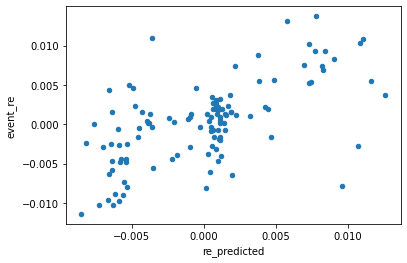

In [60]:
ump_stats.loc[ump_stats['pa']>6000].plot.scatter(x='re_predicted', y='event_re')

<AxesSubplot:xlabel='umpire_h_id'>

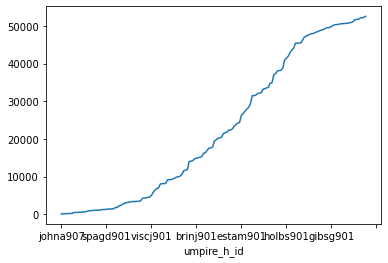

In [61]:
ump_stats.sort_values(by='pa').pa.plot()

In [62]:
ump_stats['re_effect_obs'] = ump_stats['event_re']-ump_stats['re_predicted']
ump_stats.sort_values(by='pa')

,pa,re_predicted,event_re,re_effect_obs
umpire_h_id,,,,
johna907,81,-0.017033,0.003564,0.020597
lollm901,161,-0.013334,-0.022853,-0.009519
gosnj901,164,-0.006834,0.005093,0.011927
rakos901,184,-0.018237,-0.027676,-0.009438
byrnj902,216,-0.013595,-0.035038,-0.021444
...,...,...,...,...
diazl901,51830,0.001113,-0.001620,-0.002733
millb901,52146,0.000399,-0.006074,-0.006474
herna901,52253,0.000732,-0.001684,-0.002416


<AxesSubplot:>

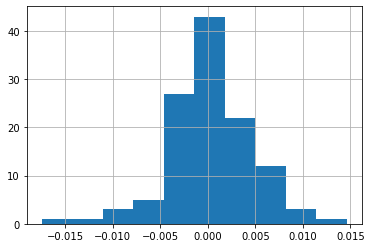

In [63]:
ump_stats.loc[ump_stats['pa']>6000].re_effect_obs.hist()

In [64]:
ump_stats.loc[ump_stats['pa']>6000].sort_values(by='re_effect_obs')

,pa,re_predicted,event_re,re_effect_obs
umpire_h_id,,,,
hirsm901,8064,0.009609,-0.007839,-0.017447
craft901,11700,0.010690,-0.002734,-0.013424
shulj901,6836,0.012592,0.003727,-0.008865
hirsj901,32069,0.001944,-0.006446,-0.008390
eddid901,51154,0.000118,-0.008098,-0.008216
...,...,...,...,...
wolcq901,14725,-0.006359,0.001595,0.007955
woodt901,8145,-0.004938,0.004561,0.009498
lentn901,9205,-0.005192,0.004979,0.010171
